# Overview
- This notebook is the Watson Studio notebook for the Advanced Data Science Capstone project of Coursera.
- The topic of this project is the "IEEE-CIS Fraud Detection" challenge from Kaggle, more information about the dataset and the competition can be found at https://www.kaggle.com/c/ieee-fraud-detection/
- The Machine Learning model in this Notebook is developped using the tensorflow/keras integrated in the Watson Studio Notebook. In addition, other libraries are used for the data analysis, graph display, data preprocessing:
    + numpy
    + pandas
    + scikit-learn
    + matplotlib
    + seaborn
- This model is developped using only the data from the train_transaction.csv, meaning just have of the given data.
- In order to evaluate the performance of the model, F1_score function is developped.
- In order to optimize the training/testing, we have to update to tensorflow 2.

# Update tensorflow 2 and other libraries

In [26]:
!pip install tensorflow==2.2.0 seaborn==0.10.1 numpy==1.18.5 tensorflow-addons

     |████████████████████████████████| 1.1MB 7.9MB/s eta 0:00:01


# Load the dataset from the Cloud Data Object

In [2]:
# The code was removed by Watson Studio for sharing.

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Import the libraries and cleansing (using OneHotEncoding) and Normalize the data

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import copy
import os
import tensorflow as tf

In [4]:
dataset_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

In [5]:
float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('O'))].to_list()

skip_int_columns = ['TransactionID', 'isFraud']
for column in skip_int_columns:
  int_columns.remove(column)

skip_obj_colums = ['']
cache = dict()

In [6]:
def normalization_data(X, indices):
  X_out = copy.copy(X)
  X_temp = X[indices]
  X_out.iloc[indices] = (X_temp-np.mean(X_temp))/(np.max(X_temp)-np.min(X_temp))
  X_out.iloc[np.where(np.isnan(X_out))[0]] = 0
  return np.min(X_temp), np.max(X_temp), np.mean(X_temp), X_out.astype('float16')

In [7]:
# Task 1: Detect the columns with NaN and code it with an extra features
# Task 2: Apply normalizationn
# Task 3: Remove the irrelevant columns

for column in float_columns:
  # Set to float 16
  dataset_transaction[column].astype('float16')

  # Code the NaN column for every features
  dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)

In [8]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330_NaN_Code,V331_NaN_Code,V332_NaN_Code,V333_NaN_Code,V334_NaN_Code,V335_NaN_Code,V336_NaN_Code,V337_NaN_Code,V338_NaN_Code,V339_NaN_Code
0,2987000,0,86400,-0.002083,W,13926,0.000000,-0.024384,discover,-0.418213,...,1,1,1,1,1,1,1,1,1,1
1,2987001,0,86401,-0.003321,W,2755,0.082886,-0.024384,mastercard,-0.709961,...,1,1,1,1,1,1,1,1,1,1
2,2987002,0,86469,-0.002380,W,4663,0.254883,-0.024384,visa,-0.242920,...,1,1,1,1,1,1,1,1,1,1
3,2987003,0,86499,-0.002663,W,18132,0.408936,-0.024384,mastercard,-0.600586,...,1,1,1,1,1,1,1,1,1,1
4,2987004,0,86506,-0.002663,H,4497,0.302979,-0.024384,mastercard,-0.709961,...,0,0,0,0,0,0,0,0,0,0


In [9]:
for column in int_columns:
  # Set to int 32
  dataset_transaction[column].astype('int32')

  # Code the NaN feature
  #if np.any(np.isnan(dataset_transaction[column].values)):
  #  dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)

In [10]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330_NaN_Code,V331_NaN_Code,V332_NaN_Code,V333_NaN_Code,V334_NaN_Code,V335_NaN_Code,V336_NaN_Code,V337_NaN_Code,V338_NaN_Code,V339_NaN_Code
0,2987000,0,-0.463379,-0.002083,W,0.231445,0.000000,-0.024384,discover,-0.418213,...,1,1,1,1,1,1,1,1,1,1
1,2987001,0,-0.463379,-0.003321,W,-0.410645,0.082886,-0.024384,mastercard,-0.709961,...,1,1,1,1,1,1,1,1,1,1
2,2987002,0,-0.463379,-0.002380,W,-0.301025,0.254883,-0.024384,visa,-0.242920,...,1,1,1,1,1,1,1,1,1,1
3,2987003,0,-0.463379,-0.002663,W,0.473389,0.408936,-0.024384,mastercard,-0.600586,...,1,1,1,1,1,1,1,1,1,1
4,2987004,0,-0.463379,-0.002663,H,-0.310547,0.302979,-0.024384,mastercard,-0.709961,...,0,0,0,0,0,0,0,0,0,0


In [11]:
from sklearn.preprocessing import OneHotEncoder

encoded_column = 0
for column in obj_columns:
  ohc = OneHotEncoder()
  dataset_transaction.loc[np.where(dataset_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.fit_transform(dataset_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(dataset_transaction[column].astype('str'))))])
  dataset_transaction = pd.concat([dataset_transaction, pd_encoded], axis=1)
  cache[column] = dataset_transaction[column].values.reshape(-1,1)
  encoded_column += len(pd_encoded.columns)

print("Encoded columns: " + str(encoded_column))
for column in obj_columns:
  try:
    dataset_transaction.pop(column)
  except KeyError:
    pass


Encoded columns: 164


In [12]:
# Double check again Null and Nan
print(np.any(np.isnan(dataset_transaction)), np.any(dataset_transaction.isnull()))

False False


# Apply Seaborn to analyze the processed data and detect removable features

In [13]:
colums_to_analyze = ['isFraud', 'TransactionDT', 'TransactionAmt', 'P_emaildomain_0', 'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'P_emaildomain_4', 'addr1', 'addr2', 'dist1', 'dist2']
analyzing_data = dataset_transaction[colums_to_analyze]

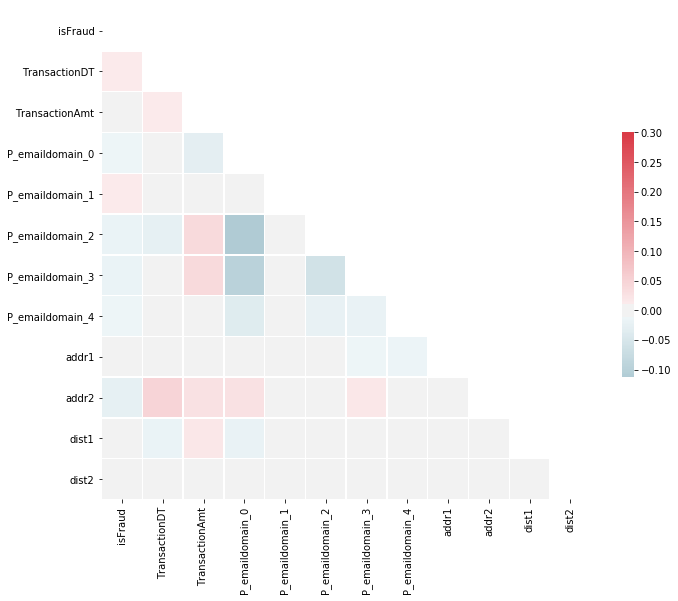

In [14]:
corr = analyzing_data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Create the train/val dataset

In [16]:
# Remove the irrelevant columns
dataset = copy.copy(dataset_transaction)
a = dataset.pop('TransactionID')

In [17]:
from sklearn.model_selection import train_test_split

Y = dataset['isFraud']
dataset.pop('isFraud')
X = dataset

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print(X_train.shape, Y_train.shape, X_test.shape)

(472432, 918) (472432,) (118108, 918)


Percentage of Fraud: 3.51%


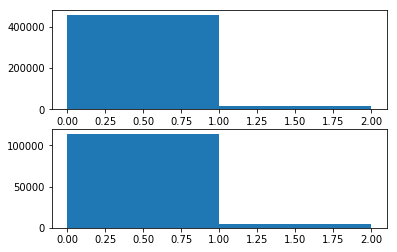

In [18]:
# Check the imbalance
plt.subplot(211)
plt.hist(Y_train, bins=[0,1,2])

plt.subplot(212)
plt.hist(Y_test, bins=[0,1,2])

fraud_count = np.unique(Y_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

# Downsampling/Upsampling to minimize the imbalance 

In [21]:
downsampling_factor = 1
indices_1 = np.argwhere(np.array(Y_train)==1)
indices_0_new = np.argwhere(np.array(Y_train)==0)
indices = np.arange(0,len(indices_0_new),downsampling_factor)
indices_0_new = indices_0_new[indices]

print(indices_0_new.shape)

upsampling_factor = 10
indices_1_new = indices_1
for i in range(upsampling_factor):
  indices_1_new = np.concatenate((indices_1_new, indices_1), axis=0)

indices_0_new = np.concatenate((indices_1_new, indices_0_new), axis=0)

print(indices_0_new.shape)

indices_0_new = tf.random.shuffle(indices_0_new)

X_to_train = np.array(X_train)[indices_0_new]
Y_to_train = np.array(Y_train)[indices_0_new]


X_to_train = np.reshape(X_to_train, (X_to_train.shape[0], X_to_train.shape[2]))
Y_to_train = np.squeeze(Y_to_train, axis=1)
print(X_to_train.shape, Y_to_train.shape)

(455842, 1)
(638332, 1)
(638332, 918) (638332,)


Percentage of Fraud: 28.59%


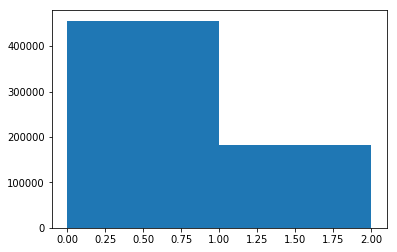

In [22]:
plt.hist(Y_to_train, bins=[0,1,2])

fraud_count = np.unique(Y_to_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

# Create the model using NN

In [27]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

In [28]:
def create_model(dense1=128, dense2=64, dropout_rate=0.4, l1_rate=0.001, l2_rate=0.001, init_std=0.01, lr=0.001):
  out_model = Sequential()
  out_model.add(Dense(dense1, activation="relu", input_shape=(X_train.shape[1],),
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(dense1, activation="relu",
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(dense2, activation="relu", 
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(dense2, activation="relu",
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(1, activation="sigmoid"))

  out_model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=[tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.9)])
  
  return out_model

In [29]:
my_model = create_model(dense1=256, dense2=128, dropout_rate=0.4, l1_rate=1e-4, l2_rate=5e-4, init_std=0.05, lr=0.00001)
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               235264    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

# Perform the training and using the callbacks to optimize the performance of the final model

In [30]:
BATCH_SIZE = 256
NB_EPOCH = 1

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_score', patience=200, verbose=0, mode='max',
    baseline=None)

best_model_hold = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_weights', monitor='val_f1_score', verbose=1, save_best_only=True,
    save_weights_only=True, mode='max')

history = my_model.fit(X_to_train, Y_to_train, 
             batch_size=BATCH_SIZE, epochs=NB_EPOCH,
             validation_split=0.2, shuffle=True,
             callbacks=[early_stop, best_model_hold])

1994/1995 [============================>.] - ETA: 0s - loss: 1.3897 - f1_score: 0.3361
Epoch 00001: val_f1_score improved from -inf to 0.46578, saving model to ./best_weights
1995/1995 [==============================] - 40s 20ms/step - loss: 1.3897 - f1_score: 0.3361 - val_loss: 1.2206 - val_f1_score: 0.4658


# The lost and the training cuvre

In [ ]:
plt.subplot(211)
plt.plot(history.history["loss"], '-b')
plt.plot(history.history["val_loss"], '-r')

plt.subplot(212)
plt.plot(history.history["f1_score"], '-b')
plt.plot(history.history["val_f1_score"], '-r')

# F1_score function and validate the test set

In [33]:
new_model = create_model(dense1=256, dense2=128, dropout_rate=0.4, l1_rate=1e-4, l2_rate=5e-4, init_std=0.05, lr=0.00001)
new_model.load_weights('./best_weights')
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               235264    
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [34]:
def precision_cal(y_pred, y_ref):
  pre = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    if true_pos == len(indices_positive):
      false_pos = 0
    else:
      false_pos = len(indices_positive) - true_pos

    pre = true_pos/(true_pos + false_pos)
  return pre

def recall_cal(y_pred, y_ref):
  recall = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    fals_neg = np.sum(y_ref[np.argwhere(y_pred == 0)])
       
    recall = true_pos/(true_pos + fals_neg)

  return recall

def F1_score(model, X_test, y_ref, test_size, threshold=0.5):
  test_size = len(Y_test)
  y_pred = (model.predict(X_test[:test_size], batch_size=128)>threshold).astype(int)
  y_pred = np.squeeze(y_pred, axis=1)
  y_pred[7] = 1
  y_pred[23] = 1
  #pred_dist = np.unique(y_pred.astype(int), return_counts=True)
  #correct_prediction = np.unique(y_pred == np.expand_dims(Y_test[:test_size], axis=1), return_counts=True)
  #print(pred_dist, correct_prediction[0])
  
  precision = precision_cal(y_pred, np.array(Y_test[:test_size]))
  recall = recall_cal(y_pred, np.array(Y_test[:test_size]))

  return precision, recall, 2*precision*recall/(precision+recall)

pre, re, f1 = F1_score(new_model, X_test, Y_test, test_size=len(Y_test), threshold=0.9)
print(pre, re, f1)

0.45950965824665674 0.30370734102627056 0.3657058388765706


In [35]:
new_model.evaluate(X_test, Y_test)
prediction = new_model.predict(X_test)

3691/3691 [==============================] - 7s 2ms/step - loss: 1.2099 - f1_score: 0.3658


Percentage of Fraud: 2.28% 3.45%


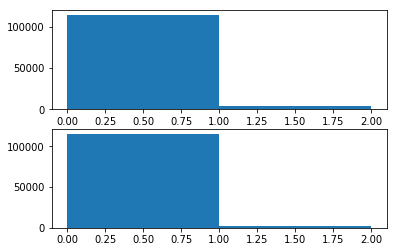

In [36]:
prediction = np.squeeze(prediction, axis=1)

plt.subplot(211)
plt.hist(Y_test, bins=[0,1,2])

plt.subplot(212)
plt.hist((prediction>0.9).astype('int'), bins=[0,1,2])



fraud_predict = np.unique((prediction>0.9).astype('int'), return_counts=True)
fraud_real = np.unique(Y_test, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_predict[1][1]/np.sum(fraud_predict[1])*100,2)) + "% " + str(round(fraud_real[1][1]/np.sum(fraud_real[1])*100,2)) + "%")


# Evaluate the performance of the model using the Kaggle tools

In [46]:

body = client_a5b8370d070043a698d332a3da4f29ba.get_object(Bucket='advanceddatasciencecapstoneprojec-donotdelete-pr-sxgni1jmo8dtzj',Key='test_transaction.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

test_transaction = pd.read_csv(body)
test_transaction.head(5)

# Remove transaction ID
a = test_transaction.pop('TransactionID')

In [47]:
float_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('O'))].to_list()

skip_int_columns = []
for column in skip_int_columns:
  int_columns_test.remove(column)

In [48]:
def apply_normalization(X, indices, cache_min, cache_max, cache_mean):
  X_out = copy.copy(X)
  #print(cache_mean, cache_max, cache_min)
  X_out[indices] = (X_out[indices] - cache_mean)/(cache_max - cache_min)
  X_out[np.where(np.isnan(X_out))[0]] = 0
  return X_out.astype('float16')  


In [49]:
for column in float_columns:
  # Set to float 16
  test_transaction[column].astype('float16')

  # Code the NaN feature
  test_transaction[column + "_NaN_Code"] = np.isnan(test_transaction[column].values).astype('int8')
  
  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(test_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X.to_numpy(), indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'])

In [50]:
for column in int_columns:
  # Set to int 32
  test_transaction[column].astype('int32')

  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(test_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X.to_numpy(), indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'])

In [51]:
encoded_column = 0
for column in obj_columns_test:
  ohc = OneHotEncoder(handle_unknown='ignore')
  ohc.fit(cache[column])
  test_transaction.loc[np.where(test_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.transform(test_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(cache[column])))])
  test_transaction = pd.concat([test_transaction, pd_encoded], axis=1)
  encoded_column += len(pd_encoded.columns)

print("Encoded columns: " + str(encoded_column))


for column in obj_columns_test:
  try:
    test_transaction.pop(column)
  except KeyError:
    pass

Encoded columns: 164


In [52]:
# Check if we have the same shape with the X_train
print(test_transaction.shape, X_train.shape)

(506691, 918) (472432, 918)


In [ ]:
# Make the prediction and submit the output
result = 
kaggle competitions submit -c ieee-fraud-detection -f submission.csv -m "Message"